<a href="https://colab.research.google.com/github/zzhenxi/Competitions/blob/main/%5BDACON%5D%ED%95%9C%EA%B5%AD%EC%96%B4%EB%AC%B8%EC%9E%A5%EA%B4%80%EA%B3%84%EB%B6%84%EB%A5%98%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C_%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 대회에 관하여
[DACON 한국어 문장 관계 분류 경진 대회](https://dacon.io/competitions/official/235875/overview/description)
* 해당 노트북은 colab 환경에서 작성되었습니다.
* 해당 대회는 종료되었으나, 연습을 위해 참가하였습니다. 
* 모든 진행 사항 중 **데이터 전처리**과정을 담은 노트북입니다.

# Load dataset

down받은 데이터 셋 unzip 해주기 

In [1]:
%cd /content/drive/MyDrive/dacon/한국어 문장 관계 분류/dataset

/content/drive/MyDrive/dacon/한국어 문장 관계 분류/dataset


In [2]:
# !unzip -qq '/content/drive/MyDrive/dacon/한국어 문장 관계 분류/open.zip'

data 불러오기

In [3]:
import pandas as pd

train_data = pd.read_csv('open/train_data.csv')
test_data = pd.read_csv('open/test_data.csv')
sample_submission = pd.read_csv('open/sample_submission.csv')

# Data EDA

In [60]:
train_data.head()

,index,premise,hypothesis,label
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral


In [52]:
train_data.shape

(24998, 4)

column에 대한 설명은 다음과 같다.
* index
* Premise : 실제 text
* Hypothesis : 가설 text
* Label : 참(Entailment) 또는 거짓(Contradiction) 또는 중립(Neutral)
  * 여기서 중립(Neutral)이란 참인지 거짓인지 판단할 수 없는 문장을 말한다.

데이터는 총 24998개이다.

In [48]:
p_texts = list(train_data['premise'])
h_texts = list(train_data['hypothesis'])

## 1) 문장 토큰의 개수

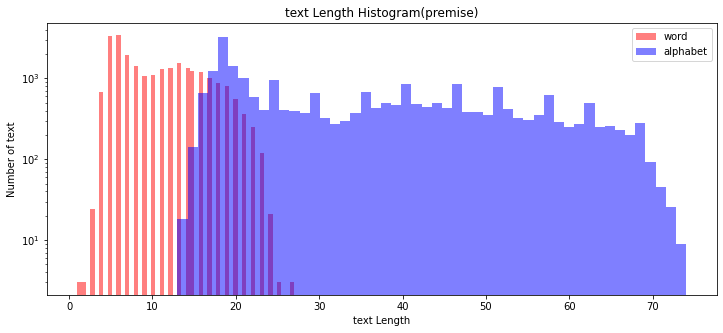

In [6]:
# 문자열 문장 리스트를 토크나이즈(공백으로 구분)
p_tokenized_reviews = [t.split() for t in p_texts]
h_tokenized_reviews = [t.split() for t in h_texts]

# 토크나이즈 된 리스트에 대한 각 길이를 저장
p_review_len_by_token = [len(t) for t in p_tokenized_reviews]
h_review_len_by_token = [len(t) for t in h_tokenized_reviews]

# 토크나이즈 된 것을 붙여서 음절의 길이를 저장
p_review_len_by_eumjeol = [len(s.replace(' ', '')) for s in p_texts]
h_review_len_by_eumjeol = [len(s.replace(' ', '')) for s in h_texts]


import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.hist(p_review_len_by_token, bins=50, alpha=0.5, color= 'r', label='word')
plt.hist(p_review_len_by_eumjeol, bins=50, alpha=0.5, color='b', label='alphabet')
plt.yscale('log', nonposy='clip')

plt.yscale('log', nonposy='clip')
# 그래프 제목
plt.title('text Length Histogram(premise)')
# 그래프 x 축 라벨
plt.xlabel('text Length')
# 그래프 y 축 라벨
plt.ylabel('Number of text')
plt.legend()

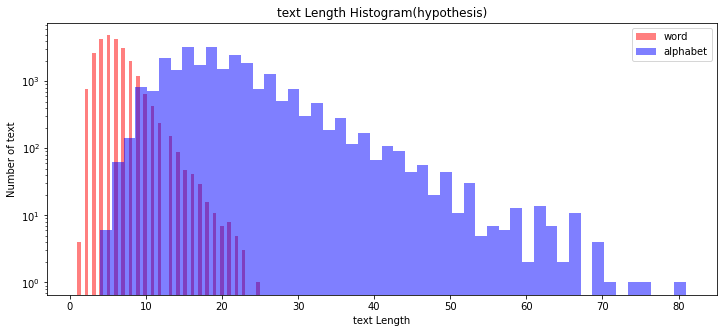

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.hist(h_review_len_by_token, bins=50, alpha=0.5, color= 'r', label='word')
plt.hist(h_review_len_by_eumjeol, bins=50, alpha=0.5, color='b', label='alphabet')
plt.yscale('log', nonposy='clip')

plt.yscale('log', nonposy='clip')
# 그래프 제목
plt.title('text Length Histogram(hypothesis)')
# 그래프 x 축 라벨
plt.xlabel('text Length')
# 그래프 y 축 라벨
plt.ylabel('Number of text')
plt.legend()

hypothesis 같은 경우, 문장의 길이가 비교적 짧은 것이 많다는 것을 알 수 있다. 

## 2) boxplot 그리기

In [9]:
import numpy as np

def make_boxplot(text_list):
  print('문장 최대길이: {}'.format(np.max(text_list)))
  print('문장 최소길이: {}'.format(np.min(text_list)))
  print('문장 평균길이: {:.2f}'.format(np.mean(text_list)))
  print('문장 길이 표준편차: {:.2f}'.format(np.std(text_list)))
  print('문장 중간길이: {}'.format(np.median(text_list)))
  # 사분위의 대한 경우는 0~100 스케일로 되어있음
  print('제 1 사분위 길이: {}'.format(np.percentile(text_list, 25)))
  print('제 3 사분위 길이: {}'.format(np.percentile(text_list, 75)))

  plt.figure(figsize=(12, 5))
  # 박스플롯 생성
  # 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
  # labels: 입력한 데이터에 대한 라벨
  # showmeans: 평균값을 마크함

  grid = (1,2)

  plt.subplot2grid(grid, (0,0),rowspan=1,colspan=1)
  plt.boxplot([text_list],
              labels=['token'],
              showmeans=True)

  plt.subplot2grid(grid, (0,1),rowspan=1,colspan=1)
  plt.boxplot([text_list],
              labels=['Eumjeol'], 
              showmeans=True)

boxplot for premise
문장 최대길이: 27
문장 최소길이: 1
문장 평균길이: 10.74
문장 길이 표준편차: 4.99
문장 중간길이: 10.0
제 1 사분위 길이: 6.0
제 3 사분위 길이: 15.0
boxplot for hypothesis
문장 최대길이: 25
문장 최소길이: 1
문장 평균길이: 5.84
문장 길이 표준편차: 2.40
문장 중간길이: 5.0
제 1 사분위 길이: 4.0
제 3 사분위 길이: 7.0


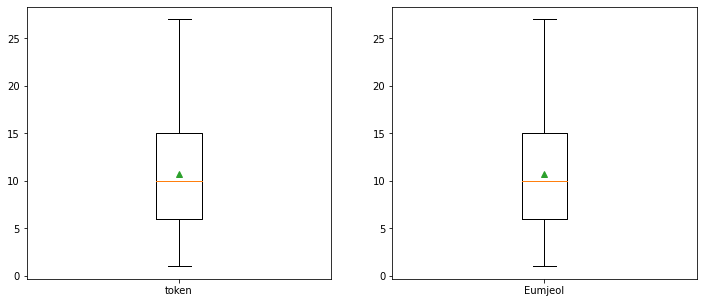

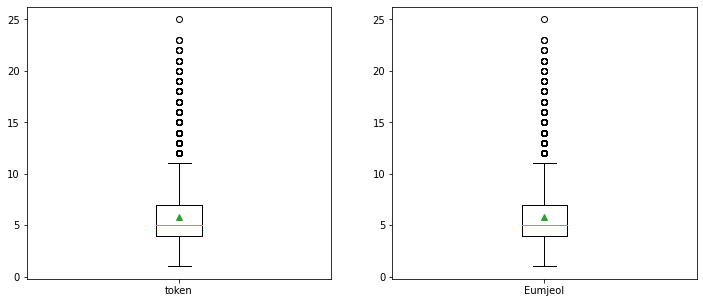

In [11]:
print("boxplot for premise")
make_boxplot(p_review_len_by_token)
print("boxplot for hypothesis")
make_boxplot(h_review_len_by_token)

## 3) label 분포 확인

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


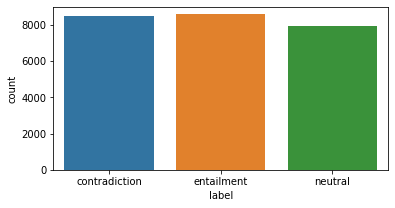

In [17]:
import seaborn as sns
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(train_data['label'])

label은 일정하다

# Data preprocessing

## 1) 결측치 확인

In [4]:
# 결측치 확인 
train_data.isnull().sum()

index         0
premise       0
hypothesis    0
label         0
dtype: int64

In [5]:
test_data.isnull().sum()

index         0
premise       0
hypothesis    0
label         0
dtype: int64

## 2) 특수문자 제거

**삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...** 에서 **자작극을 벌인 이는 3명이다.**를 예측한 경우처럼 숫자가 예측에 영향을 미칠 수 있으므로 숫자를 제거하지 않는게 좋다고 생각하였다. 

제거한 사항들은 다음과 같다.
* 특수문자 
* 한국어를 제외한 외국어

In [9]:
# 외국어를 제거하기 전에 영어가 포함되어 있는 문장을 직접 살펴보자.
import re
cnt = 0
for t in train_data['premise']:
  regexp = re.compile(r'[a-zA-Z]')
  if regexp.search(t):
    print(t)
  else :
    cnt += 1
if cnt == len(train_data['premise']):
  print("모든 문장이 한글로 이루어졌음!")

모든 문장이 한글로 이루어졌음!


모든 문장이 한글로 이루어졌으므로 크게 신경쓰지 않아도 될 것 같다. 맘 놓고 cleaning을 해준다.

In [62]:
train_data.head()

,index,premise,hypothesis,label
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral


In [7]:
def clean_text(texts): 
    corpus = [] 
    for t in texts: 
      t = re.sub(r'[^ ㄱ-ㅣ가-힣0-9+]', '', t) # 한글과 숫자를 제외한 모든 글자 제거
      t = re.sub(r'\s+', ' ', t) #extra space 제거
      t = re.sub(r"^\s+", '', t) #space from start 제거
      t = re.sub(r'\s+$', '', t) #space from the end 제거
      corpus.append(t) 
    return corpus

In [11]:
temp = clean_text(train_data['premise']) #메소드 적용
train_data['premise'] = temp

temp = clean_text(train_data['hypothesis']) #메소드 적용
train_data['hypothesis'] = temp

temp = clean_text(test_data['premise']) #메소드 적용
test_data['premise'] = temp

temp = clean_text(test_data['hypothesis']) #메소드 적용
test_data['hypothesis'] = temp

# dataframe 확인
train_data.head()

,index,premise,hypothesis,label
0,0,씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서 소년이나 장정들이 ...,씨름의 여자들의 놀이이다,contradiction
1,1,삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나 ...,자작극을 벌인 이는 3명이다,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다,neutral
4,4,진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면 이런 상황에서는 ...,이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다,neutral


## 3) 형태소 분석을 통한 핵심 단어 추출

In [ ]:
!pip install konlpy

okt 형태소 분석기를 이용하여 특정 태그에 해당하는 토큰만 추출한다. 
**조사, 접속사, 감탄사 등이 포함되지 않는다.** [konlpy 품사 태그 표](https://velog.velcdn.com/images%2Fhsoh0423%2Fpost%2F75107d78-010f-4a73-ad87-117c6acfd551%2F%ED%92%88%EC%82%AC%20%ED%83%9C%EA%B7%B8%ED%91%9C.jpg)

okt 형태소 분석기를 사용한 이유
* 형태소를 나누는 것이 너무 복잡하지 않았음 (너무 복잡하면 오히려 문장이 엉망진창이 될 것 같았다.)
* 계산 시간이 오래 걸리지 않음

In [34]:
from konlpy.tag import Okt
okt = Okt()

def pos_tagging(dataframe, col_name):
  main_words_list = []
  for t in dataframe[col_name]:
    tem = okt.pos(t, norm=True, stem=True, join=True)
    main_words = [t.split('/')[0] for t in tem if t.split('/')[1] in ('Noun', 'Verb', 'Adjective', 'Determiner', 
                                                                      'Adverb', 'PreEimi', 'Eomi', 'Suffix', 'Number', 'Unknown')]
    main_words_str = " ".join(main_words)
    main_words_list.append(main_words_str)
  
  # dataframe에 새로운 열(col)로 추가
  new_col_name = col_name + '_main'
  dataframe[new_col_name] = main_words_list

In [35]:
# pos_tagging 함수를 사용하여 핵심 단어(main_words)만 포함하는 문장을 반환한 컬럼 새로 만들기
pos_tagging(train_data, 'premise')
pos_tagging(train_data, 'hypothesis')

pos_tagging(test_data, 'premise')
pos_tagging(test_data, 'hypothesis')

In [36]:
train_data.head()

,index,premise,hypothesis,label,premise_main,hypothesis_main
0,0,씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서 소년이나 장정들이 ...,씨름의 여자들의 놀이이다,contradiction,씨름 상고 시대 로부터 전해지다 내려오다 남자 들 대표 적 놀이 로서 소년 장정 들...,씨름 여자 들 놀이
1,1,삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나 ...,자작극을 벌인 이는 3명이다,contradiction,삼성 자작 극 벌이다 2 명 형사 고소 등 법적 대응 검토 중이 하다 중국 내 여론...,자작 극 벌이다 이다 3 명
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다,entailment,이르다 위해 예측 적 범죄예방 시스템 구축 고도 화하다,예측 적 범죄예방 시스템 구축 고도화 하다 것 목적 있다 때문
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다,neutral,광주 광역시 재개발 정비 사업 원주민 들 대한 종합 대책 마련 하다 등 원주민 보호...,원주민 들 종합 대책 만족하다
4,4,진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면 이런 상황에서는 ...,이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다,neutral,진정 소비자 직원 들 사랑 받다 기업 오래 지속 되다 싶다 이렇다 상황 책임 있다 ...,이렇다 상황 책임 있다 모습 보여주다 기업 아주 드물다


# Save preprocessed data

In [37]:
pwd

'/content/drive/MyDrive/dacon/한국어 문장 관계 분류/dataset'

In [39]:
train_data.to_csv('ppcd_train_data.csv') # ppsd = preprocessed
test_data.to_csv('ppcd_test_data.csv')